In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import sys; sys.path.append('.')

env: CUDA_VISIBLE_DEVICES=0


In [2]:
#TMP - rm when format gets fixed
_='\n'.join(filter(len, open("./data/bpe_parallel2.txt").read().split('\n')))
open("./data/bpe_parallel2.txt", 'w').write(_)

5453204

In [3]:
import numpy as np
from vocab import Vocab
inp_voc = Vocab.from_file("./data/1.voc")
out_voc = Vocab.from_file("./data/2.voc")

In [4]:
import tensorflow as tf
import models.transformer as tr
from lib.tensor_utils import infer_length, infer_mask

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction=0.333

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

mini_hp = {
        'hid_size': 256,
        'ff_size': 1024,
        'num_heads': 4,
        'num_layers': 2,
    
        'rescale_emb': True,
        'relu_dropout': 0.,
        'res_dropout': 0.,
        'attn_dropout': 0.,
        'inp_emb_bias': True,
        'res_steps': 'nlda',
        'normalize_out': True,
        'force_bos': True,
}

model = tr.Model('mod',inp_voc,out_voc,**mini_hp)

/home/user32878/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
from prefetch_generator import background
from itertools import islice, chain
from tqdm import tqdm
class train:
    #TODO use batch_iterator or merge with it
    #TODO port length-aware batch iterator
    @background(max_prefetch=100)
    def iterate_lines(batch_size=16, batches_per_epoch=None, skip_lines=0,
                      src_path = "./data/bpe_parallel1.txt",
                      dst_path = "./data/bpe_parallel2.txt",
                      ):
        while True:
            with open(src_path) as f_src, open(dst_path) as f_dst:
                
                num_lines = batches_per_epoch * batch_size if batches_per_epoch is not None else None
                
                f_src = islice(f_src, skip_lines, num_lines)
                f_dst = islice(f_dst, skip_lines, num_lines)

                batch = []
                for src_line, dst_line in zip(f_src, f_dst):
                    if len(src_line) ==0 or len(dst_line)==0: continue
                    
                    batch.append([src_line[:-1], dst_line[:-1]])
                    if len(batch) >= batch_size:
                        yield (batch)
                        batch = []
                
                if batches_per_epoch is not None:
                    raise StopIteration()        
    
class dev:
    dev_src = "./data/bpe_parallel1.txt"
    dev_dst = "./data/bpe_parallel2.txt"

    inp_lines = np.array(open(dev_src).read()[:-1].split('\n'))
    out_lines = np.array(open(dev_dst).read()[:-1].split('\n'))

In [6]:
from bleu import compute_bleu

In [7]:
_dummy = np.arange(5,30, dtype='int32').reshape([5,5])
inp = tf.placeholder_with_default(_dummy, [None,None])
out = tf.placeholder_with_default(_dummy, [None,None])

In [8]:
logits = model.symbolic_score(inp, out, is_train=True)
# logits are already alligned with out

In [9]:
from lib.tensor_utils import infer_mask, initialize_uninitialized_variables

nll = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=out)

loss = nll * infer_mask(out, out_voc.eos, dtype=tf.float32)

loss = tf.reduce_sum(loss, axis=1)
loss = tf.reduce_mean(loss)

In [10]:
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, model.name)
grads = tf.gradients(loss, weights)
grads = tf.clip_by_global_norm(grads, 100)[0]
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).apply_gradients(zip(grads,weights))

In [11]:
initialize_uninitialized_variables(sess)

In [12]:
sess.run(tf.global_variables_initializer())

In [13]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import count
from pandas import ewma
from tqdm import tqdm
from time import sleep
epoch = 0
loss_history = []

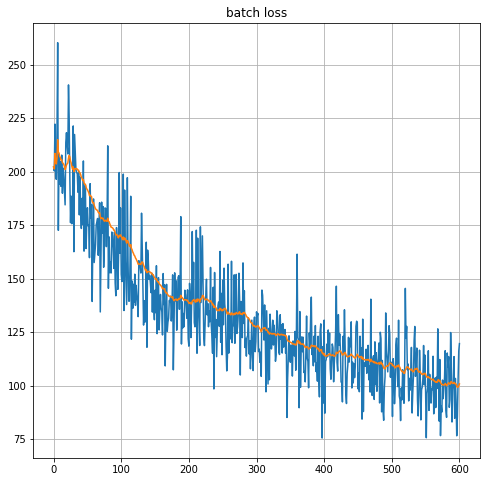

490it [11:20,  1.39s/it]

In [ ]:
batch_size = 32
for i, batch in enumerate(tqdm(train.iterate_lines(batch_size, batches_per_epoch=None))):
    batch_src, batch_dst = zip(*batch)
    batch_src_ix = inp_voc.tokenize_many(batch_src)
    batch_dst_ix = out_voc.tokenize_many(batch_dst)
    
    feed_dict = {inp: batch_src_ix, out: batch_dst_ix}
    
    loss_t = sess.run([train_step, loss], feed_dict)[1]
    loss_history.append(np.mean(loss_t))
    
        
    if (epoch+1) % 500 == 0:
        #test_bleu_history.append([epoch,compute_bleu(model, dev.inp_lines[::5], dev.out_lines[::5])[0]])
        
        
        w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="mod/")
        w_values = sess.run(w_variables)
        weights_dict = {w.name: w_val for w, w_val in zip(w_variables,w_values)}
        np.savez("./model-%i.npz"%epoch, **weights_dict)
        
    
    if epoch % 10 == 0:
        clear_output(True)
        plt.figure(figsize=[8,8])
        plt.title("batch loss")
        plt.plot(loss_history)
        plt.plot(ewma(np.array(loss_history),span=50))
        plt.grid()
        plt.show()
    epoch +=1
        

In [17]:
trans = model.symbolic_translate(inp)

/home/user32878/yozhedir/babelSolution/lib/sliced_argmax.so


In [18]:
sess.run(trans.best_out, feed_dict)

array([[   0,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
       [   0, 7857, 7857, 7857, 7857, 7857, 7857,   88,    1,    1,    1],
       [   0,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
       [   0,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
       [   0, 7857, 7857, 7857,   88,    1,    1,    1,    1,    1,    1],
       [   0, 7857,   88,    1,    1,    1,    1,    1,    1,    1,    1],
       [   0,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
       [   0, 7857, 7857, 7857,   88,    1,    1,    1,    1,    1,    1],
       [   0, 7857,   88,    1,    1,    1,    1,    1,    1,    1,    1],
       [   0, 7857, 7857, 7857, 7857, 7857, 7857, 7857, 7857,   88,    1],
       [   0,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
       [   0, 7857, 7857, 7857, 7857, 7857, 7857, 7857,   88,    1,    1],
       [   0,   88,    1,    1,    1,    1,    1,    1,    1,    1,    1],
       [   0, 7857, 7857,

In [19]:
sess.run(trans.best_scores, feed_dict)

array([ -5.95697737, -43.7395134 ,  -5.94093609,  -5.9647274 ,
       -27.44266129, -16.44791412,  -5.94379568, -27.45367813,
       -16.45034218, -54.71476746,  -5.999722  , -49.22361755,
       -10.9288559 , -21.96670914, -16.45472336, -10.9454174 ,
       -21.98524094, -10.95733166,  -5.98115635, -21.99586868,
        -5.96494532,  -5.95996809,  -5.98214865, -16.45394516,
       -27.45812988,  -6.00365782, -32.90970993, -10.93470764,
        -5.97571087, -10.88978004, -32.87838745,  -5.99495602], dtype=float32)

In [20]:
logp_trans = model.symbolic_score(inp, trans.best_out)

scores = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=trans.best_out, logits=logp_trans)
scores = scores * infer_mask(trans.best_out, out_voc.eos, dtype=tf.float32)


In [23]:
scores.eval(feed_dict)[:,1:].sum(axis=1)

array([[  5.95697737,   5.95697737,   5.95697737,   5.95697737,
          5.95697737,   5.95697737,   5.95697737,   5.95697737,
          5.95697737,   5.95697737],
       [  5.58799505,  11.11808586,  16.60442734,  22.08396339,
         27.56002045,  33.03188324,  38.49030304,  43.73950958,
         43.73950958,  43.73950958],
       [  5.94093513,   5.94093513,   5.94093513,   5.94093513,
          5.94093513,   5.94093513,   5.94093513,   5.94093513,
          5.94093513,   5.94093513],
       [  5.96472692,   5.96472692,   5.96472692,   5.96472692,
          5.96472692,   5.96472692,   5.96472692,   5.96472692,
          5.96472692,   5.96472692],
       [  5.58729219,  11.11611557,  16.60194778,  22.09349632,
         27.44266319,  27.44266319,  27.44266319,  27.44266319,
         27.44266319,  27.44266319],
       [  5.61384392,  11.1410675 ,  16.44791412,  16.44791412,
         16.44791412,  16.44791412,  16.44791412,  16.44791412,
         16.44791412,  16.44791412],
       [  